<a href="https://colab.research.google.com/github/easoplee/spine_segmentation/blob/main/lumbar_spine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lumbar Spine Bone (L1-S1) Segmentation
- dataset can be accessed from: https://data.mendeley.com/datasets/k3b363f3vz/2

In [1]:
new_training = True

### Import necessary packages

In [ ]:
#pip install packages

!pip install itk
!pip install itkwidgets
!pip install pydicom
!pip install ipywidgets

In [3]:
#import necessary packages

import pathlib as Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
%matplotlib inline
import itk
import itkwidgets
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
import pandas as pd
import torch
import torch.nn as nn
import torchvision.models
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pad_sequence 
import torch.nn.functional as F
import os
import pydicom as dicom
import matplotlib.patches as mpatches
import matplotlib.animation as animation
import matplotlib.image as img
import zipfile
import cv2
from google.colab.patches import cv2_imshow
from tqdm import tqdm
import time
from PIL import Image
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

## Download the dataset from google drive

In [4]:
# mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
class config:
  BATCH_SIZE = 20
  NUM_CLASS = 7
  INPUT_IMAGE_HEIGHT = 224
  INPUT_IMAGE_WIDTH = 224
  DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
  PIN_MEMORY = True if DEVICE == "cuda" else False
  LEARNING_RATE = 3e-5
  NUM_EPOCHS = 35
  MODEL_PATH = "/content/drive/MyDrive/lumbar_mid_sagittal/output/multi_model.pth"
  PLOT_PATH = "/content/drive/MyDrive/lumbar_mid_sagittal/output/plot.png"

In [6]:
#unzip the zip file
!unzip -u "/content/drive/MyDrive/lumbar_mid_sagittal.zip" -d "/content/drive/MyDrive/"

Archive:  /content/drive/MyDrive/lumbar_mid_sagittal.zip


In [7]:
#download the image and ground truth mask
image_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Images/'
label_dir = '/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images'

#print out the number of images and labels
print(f'Total number of MRI scans: {len(os.listdir(image_dir))}')
print(f'Total number of MRI labels: {len(os.listdir(label_dir))}')

Total number of MRI scans: 514
Total number of MRI labels: 514


In [8]:
DIR_SIZE = len(os.listdir(image_dir))
print(sorted(os.listdir(image_dir)))

['T1_0001_S8.png', 'T1_0002_S8.png', 'T1_0003_S8.png', 'T1_0004_S7.png', 'T1_0005_S8.png', 'T1_0006_S8.png', 'T1_0007_S8.png', 'T1_0008_S7.png', 'T1_0009_S7.png', 'T1_0010_S8.png', 'T1_0011_S8.png', 'T1_0012_S8.png', 'T1_0013_S8.png', 'T1_0014_S8.png', 'T1_0015_S8.png', 'T1_0016_S8.png', 'T1_0017_S8.png', 'T1_0019_S8.png', 'T1_0020_S15.png', 'T1_0021_S8.png', 'T1_0022_S8.png', 'T1_0023_S8.png', 'T1_0024_S7.png', 'T1_0025_S8.png', 'T1_0026_S8.png', 'T1_0027_S14.png', 'T1_0029_S7.png', 'T1_0030_S8.png', 'T1_0031_S8.png', 'T1_0032_S8.png', 'T1_0033_S8.png', 'T1_0034_S8.png', 'T1_0035_S8.png', 'T1_0036_S8.png', 'T1_0037_S7.png', 'T1_0038_S8.png', 'T1_0039_S8.png', 'T1_0040_S8.png', 'T1_0041_S8.png', 'T1_0042_S15.png', 'T1_0043_S8.png', 'T1_0044_S8.png', 'T1_0046_S8.png', 'T1_0047_S8.png', 'T1_0048_S8.png', 'T1_0050_S8.png', 'T1_0051_S8.png', 'T1_0052_S8.png', 'T1_0053_S8.png', 'T1_0055_S15.png', 'T1_0056_S8.png', 'T1_0057_S8.png', 'T1_0058_S8.png', 'T1_0060_S8.png', 'T1_0061_S8.png', 'T1_0

## Visualize an example image and label



In [9]:
#parameters: img_dir -> string that specifies where the images are stored at; label_dir -> similar

def view_img_label(img_dir, label_dir):
  dir_size = DIR_SIZE
  #rand_int = np.random.randint(0, dir_size-1)
  rand_int=0
  ex_img_dir = os.path.join(image_dir, sorted(os.listdir(image_dir))[rand_int])
  #print(ex_img_dir)
  ex_img = cv2.imread(ex_img_dir)
  ex_label_dir = os.path.join(label_dir, sorted(os.listdir(label_dir))[rand_int])
  #print(ex_label_dir)
  ex_label = cv2.imread(ex_label_dir)
  return ex_img, ex_label, ex_img_dir, ex_label_dir

image shape: (320, 320, 3)
label shape: (320, 320, 3)


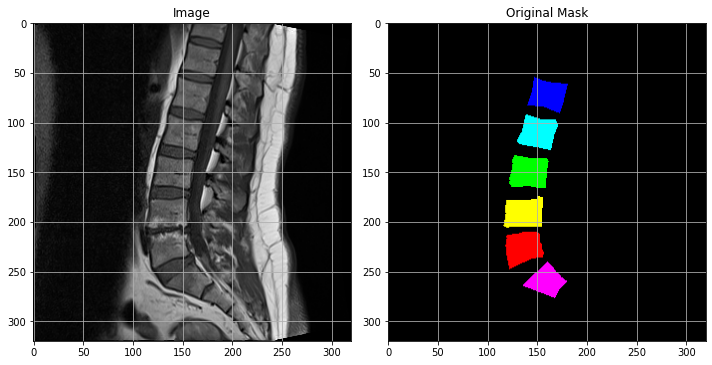

In [10]:
#!pip install matplotlib==3.1.3
ex_img, ex_label, ex_img_dir, ex_label_dir = view_img_label(image_dir, label_dir)
print(f'image shape: {ex_img.shape}')
print(f'label shape: {ex_label.shape}')
#print(ex_img)
figure, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
# plot the original image, its mask, and the predicted mask
ax[0].imshow(ex_img)
ax[1].imshow(ex_label)

# set the titles of the subplots
ax[0].set_title("Image")
ax[1].set_title("Original Mask")
ax[0].grid(True)
ax[1].grid(True)

# set the layout of the figure and display it
figure.tight_layout()
figure.show()

## Data formatting
- mask shape: [height x width] and contain class indices for each pixel location in the range (0, nb_classes=7)

In [11]:
#TODO: print out all the unique color labels

#flatten out the image -> [[R,G,B]*(width*height)]
def flatten_img(img):
  width = img.shape[0]
  height = img.shape[1]

  temp = []

  for w in range(width):
    for h in range(height):
      temp.append(img[w, h])
  return temp

ex_label_flatten = flatten_img(ex_label)

unique_data = [list(x) for x in set(tuple(x) for x in ex_label_flatten)]
print("unique RGB values: ", unique_data)

#[[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]

unique RGB values:  [[0, 255, 255], [255, 255, 0], [0, 0, 255], [255, 0, 0], [255, 0, 255], [0, 0, 0], [0, 255, 0]]


In [12]:
#given an color-coded mask, format in such that each pixel location in the range contains an integer from 0 to 7
colorToClass = {
    (0, 0, 0) : 'background',
    (255, 255, 0) : 'L1',
    (255, 0, 0) : 'L2',
    (0, 255, 0) : 'L3',
    (0, 255, 255) : 'L4',
    (0, 0, 255) : 'L5',
    (255, 0, 255) : 'S1'
}

classToInt = {
    'background': 0,
    'L1': 1,
    'L2': 2,
    'L3': 3,
    'L4': 4,
    'L5': 5,
    'S1': 6
}

IntToColor = {
    0: (0, 0, 0),
    1: (255, 255, 0),
    2: (255, 0, 0),
    3: (0, 255, 0),
    4: (0, 255, 255),
    5: (0, 0, 255),
    6: (255, 0, 255)
}

def RGBtoInt(label_img):
  temp = np.zeros((label_img.shape[0], label_img.shape[1]))
  for i in range(label_img.shape[0]):
    for j in range(label_img.shape[1]):
      temp[i, j] = int(classToInt.get(colorToClass.get(tuple(label_img[i, j]))))
  return temp

#test RGBtoInt function
test_label_Int = RGBtoInt(ex_label)
print("unique labels: ", np.unique(test_label_Int))
non_background = 0
for i in range(test_label_Int.shape[0]):
  for j in range(test_label_Int.shape[1]):
    if int(test_label_Int[i,j]) == 0:
      non_background += 1

total_pixels = test_label_Int.shape[0] * test_label_Int.shape[1]
print(f'Percentage of background: {"{:.2f}".format(non_background/total_pixels*100)}%')


unique labels:  [0. 1. 2. 3. 4. 5. 6.]
Percentage of background: 94.22%


### Resize to (config.HEIGHT, config.WIDTH)


In [13]:
def resize_img(img, img_stack=1):
  width = config.INPUT_IMAGE_WIDTH #224
  height = config.INPUT_IMAGE_HEIGHT #224
  img_stack_sm = np.zeros((width, height, img_stack)) #empty list of (3, 224, 224)

  if img_stack==1:
    img_stack_sm = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
  else:
    for idx in range(img_stack):
      img2 = img[:, :, idx]
      #print(img2.shape)
      img_sm = cv2.resize(img2, (width, height), interpolation=cv2.INTER_NEAREST)
      #print(img_sm.shape)
      img_stack_sm[:, :, idx] = img_sm
  return img_stack_sm

test_resize_img= resize_img(ex_img, 3)
print("resized image shape: ", test_resize_img.shape)

resized image shape:  (224, 224, 3)


##Create SpineData class

In [14]:
class spineData(Dataset):
  def __init__(self, path, label_path, fileList):
    #self.files = sorted(os.listdir(path))
    #self.labels = sorted(os.listdir(label_path))
    #self.transform = transform
    self.path = path
    self.labelpath = label_path
    self.fileList = fileList

  def __len__(self):
    return len(self.fileList)

  def __getitem__(self, index):
    filename = os.path.join(self.path, self.fileList[index])

    tensor_image = cv2.imread(filename)
    tensor_image = cv2.resize(tensor_image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT))
    tensor_image = torch.Tensor(tensor_image/255)
    tensor_image = torch.permute(tensor_image, (2,0,1))

    label_filename = os.path.join(self.labelpath, self.fileList[index])
    label = cv2.imread(label_filename)
    label = resize_img(RGBtoInt(label))
    tensor_label = torch.LongTensor(label)

    return tensor_image, tensor_label

## Split to train/test

In [15]:
print(image_dir)
print(label_dir)

valset_length = int(len(os.listdir(image_dir)) * 0.1)

image_list = sorted(os.listdir(image_dir))
random.shuffle(image_list)

val_list = sorted(image_list[:valset_length])
train_list = sorted(image_list[valset_length:])

print(val_list)

train_spine_dataset = spineData(image_dir, label_dir, train_list)
test_spine_dataset = spineData(image_dir, label_dir, val_list)

/content/drive/MyDrive/lumbar_mid_sagittal/Images/
/content/drive/MyDrive/lumbar_mid_sagittal/Pseudo_Colored_Ground_Truth_Images
['T1_0034_S8.png', 'T1_0046_S8.png', 'T1_0073_S15.png', 'T1_0080_S8.png', 'T1_0089_S8.png', 'T1_0097_S8.png', 'T1_0119_S8.png', 'T1_0121_S8.png', 'T1_0138_S6.png', 'T1_0145_S8.png', 'T1_0161_S15.png', 'T1_0163_S8.png', 'T1_0168_S8.png', 'T1_0184_S8.png', 'T1_0186_S8.png', 'T1_0187_S7.png', 'T1_0194_S8.png', 'T1_0202_S8.png', 'T1_0224_S8.png', 'T1_0229_S8.png', 'T1_0247_S8.png', 'T1_0252_S8.png', 'T1_0257_S8.png', 'T1_0260_S8.png', 'T1_0267_S8.png', 'T1_0281_S8.png', 'T1_0282_S8.png', 'T1_0301_S8.png', 'T1_0307_S8.png', 'T1_0331_S8.png', 'T1_0349_S8.png', 'T1_0354_S8.png', 'T1_0355_S8.png', 'T1_0359_S8.png', 'T1_0381_S8.png', 'T1_0388_S8.png', 'T1_0394_S8.png', 'T1_0395_S9.png', 'T1_0404_S8.png', 'T1_0421_S8.png', 'T1_0434_S8.png', 'T1_0441_S8.png', 'T1_0473_S8.png', 'T1_0486_S8.png', 'T1_0508_S8.png', 'T1_0519_S15.png', 'T1_0533_S8.png', 'T1_0542_S8.png', 'T1

In [16]:
#plt.imshow(spine_dataset[0][0])

print(np.unique(train_spine_dataset[0][1])) #resize with keeping new labels
print(train_spine_dataset[0][0].shape)
print(train_spine_dataset[0][1].shape)
print(len(train_spine_dataset))

print(np.unique(test_spine_dataset[0][1])) #resize with keeping new labels
print(test_spine_dataset[0][0].shape)
print(test_spine_dataset[0][1].shape)
print(len(test_spine_dataset))

[0 1 2 3 4 5 6]
torch.Size([3, 224, 224])
torch.Size([224, 224])
463
[0 1 2 3 4 5 6]
torch.Size([3, 224, 224])
torch.Size([224, 224])
51


## Make dataloaders

In [17]:
train_dataloader = DataLoader(train_spine_dataset, shuffle=True,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

train_x, train_y = next(iter(train_dataloader))

print(f'train_x = shape: {train_x.shape}; type: {train_x.dtype}')
print(f'train_x = min: {train_x.min()}; max: {train_x.max()}')
#print(f'train_y = shape: {train_y.shape}; class: {train_y.unique()}; type: {train_y.dtype}')

val_dataloader = DataLoader(test_spine_dataset, shuffle=False,
	batch_size=config.BATCH_SIZE, pin_memory=config.PIN_MEMORY,
	num_workers=os.cpu_count())

val_x, val_y = next(iter(val_dataloader))
print(f'val_x = shape: {val_x.shape}')
print(f'val_y = shape: {val_y.shape}')

dataloaders = {
  'train': train_dataloader,
  'val': val_dataloader
}

print(len(train_dataloader))
print(len(val_dataloader))

train_x = shape: torch.Size([20, 3, 224, 224]); type: torch.float32
train_x = min: 0.0; max: 0.9764705896377563
val_x = shape: torch.Size([20, 3, 224, 224])
val_y = shape: torch.Size([20, 224, 224])
24
3


## 2D U-Net Architecture

In [18]:
#import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=False, progress=True, num_classes=7, aux_loss=None)
if (not(new_training)): # if training is unnecessary
  #model.load_state_dict(torch.load(config.MODEL_PATH))
  model = torch.load(config.MODEL_PATH).to(config.DEVICE)
model = model.to(config.DEVICE)
model

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## TRAINING

In [19]:
if (new_training):
  optimizer = torch.optim.Adam(model.parameters(), lr=config.LEARNING_RATE)
  loss_function = nn.CrossEntropyLoss()

  # calculate steps per epoch for training and test set
  trainSteps = len(train_spine_dataset) // config.BATCH_SIZE
  testSteps = len(test_spine_dataset) // config.BATCH_SIZE

  # initialize a dictionary to store training history
  H = {"train_loss": [], "test_loss": []}

  print(trainSteps)

23


In [20]:
if (new_training):
  print("[INFO] training the network...")
  startTime = time.time()
  for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
      # send the input to the device
      (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
      # perform a forward pass and calculate the training loss
      pred = model(x)
      pred = pred['out']
      #print(pred.shape)
      loss = loss_function(pred, y)
      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      # add the loss to the total training loss so far
      totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
      # set the model in evaluation mode
      model.eval()
      # loop over the validation set
      for (x, y) in val_dataloader:
        # send the input to the device
        (x, y) = (x.type(torch.cuda.FloatTensor).to(config.DEVICE), y.to(config.DEVICE))
        # make the predictions and calculate the validation loss
        pred = model(x)
        pred = pred['out']
        totalTestLoss += loss_function(pred, y)
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
      avgTrainLoss, avgTestLoss))
  # display the total time needed to perform the training
  endTime = time.time()
  print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  3%|▎         | 1/35 [05:57<3:22:19, 357.04s/it]

[INFO] EPOCH: 1/35
Train loss: 1.850459, Test loss: 3.0293


  6%|▌         | 2/35 [11:36<3:10:50, 346.98s/it]

[INFO] EPOCH: 2/35
Train loss: 1.285401, Test loss: 1.3993


  9%|▊         | 3/35 [17:18<3:03:49, 344.68s/it]

[INFO] EPOCH: 3/35
Train loss: 0.970963, Test loss: 1.0341


 11%|█▏        | 4/35 [23:00<2:57:29, 343.52s/it]

[INFO] EPOCH: 4/35
Train loss: 0.801470, Test loss: 1.5178


 14%|█▍        | 5/35 [28:45<2:51:55, 343.83s/it]

[INFO] EPOCH: 5/35
Train loss: 0.706239, Test loss: 0.8307


 17%|█▋        | 6/35 [34:27<2:45:59, 343.41s/it]

[INFO] EPOCH: 6/35
Train loss: 0.619246, Test loss: 0.7535


 20%|██        | 7/35 [40:09<2:40:01, 342.90s/it]

[INFO] EPOCH: 7/35
Train loss: 0.564724, Test loss: 0.7069


 23%|██▎       | 8/35 [45:53<2:34:27, 343.26s/it]

[INFO] EPOCH: 8/35
Train loss: 0.514934, Test loss: 0.6575


 26%|██▌       | 9/35 [51:36<2:28:46, 343.32s/it]

[INFO] EPOCH: 9/35
Train loss: 0.472512, Test loss: 0.6349


 29%|██▊       | 10/35 [57:17<2:22:39, 342.40s/it]

[INFO] EPOCH: 10/35
Train loss: 0.435904, Test loss: 0.5618


 31%|███▏      | 11/35 [1:03:04<2:17:29, 343.74s/it]

[INFO] EPOCH: 11/35
Train loss: 0.405081, Test loss: 0.5273


 34%|███▍      | 12/35 [1:09:04<2:13:43, 348.85s/it]

[INFO] EPOCH: 12/35
Train loss: 0.373239, Test loss: 0.4847


 37%|███▋      | 13/35 [1:14:44<2:06:51, 345.99s/it]

[INFO] EPOCH: 13/35
Train loss: 0.347272, Test loss: 0.4445


 40%|████      | 14/35 [1:20:26<2:00:41, 344.85s/it]

[INFO] EPOCH: 14/35
Train loss: 0.324610, Test loss: 0.4297


 43%|████▎     | 15/35 [1:26:09<1:54:47, 344.38s/it]

[INFO] EPOCH: 15/35
Train loss: 0.302354, Test loss: 0.3843


 46%|████▌     | 16/35 [1:31:51<1:48:46, 343.51s/it]

[INFO] EPOCH: 16/35
Train loss: 0.284346, Test loss: 0.3659


 49%|████▊     | 17/35 [1:37:35<1:43:07, 343.77s/it]

[INFO] EPOCH: 17/35
Train loss: 0.266181, Test loss: 0.3579


 51%|█████▏    | 18/35 [1:43:18<1:37:20, 343.54s/it]

[INFO] EPOCH: 18/35
Train loss: 0.251769, Test loss: 0.3297


 54%|█████▍    | 19/35 [1:49:01<1:31:34, 343.41s/it]

[INFO] EPOCH: 19/35
Train loss: 0.235948, Test loss: 0.3160


 57%|█████▋    | 20/35 [1:54:44<1:25:49, 343.28s/it]

[INFO] EPOCH: 20/35
Train loss: 0.222417, Test loss: 0.2933


 60%|██████    | 21/35 [2:00:27<1:20:06, 343.32s/it]

[INFO] EPOCH: 21/35
Train loss: 0.211343, Test loss: 0.2834


 63%|██████▎   | 22/35 [2:06:12<1:14:28, 343.75s/it]

[INFO] EPOCH: 22/35
Train loss: 0.200192, Test loss: 0.2681


 66%|██████▌   | 23/35 [2:11:58<1:08:50, 344.24s/it]

[INFO] EPOCH: 23/35
Train loss: 0.189791, Test loss: 0.2513


 69%|██████▊   | 24/35 [2:17:42<1:03:05, 344.15s/it]

[INFO] EPOCH: 24/35
Train loss: 0.182400, Test loss: 0.2421


 71%|███████▏  | 25/35 [2:23:25<57:19, 343.91s/it]  

[INFO] EPOCH: 25/35
Train loss: 0.172330, Test loss: 0.2274


 74%|███████▍  | 26/35 [2:29:13<51:46, 345.19s/it]

[INFO] EPOCH: 26/35
Train loss: 0.164032, Test loss: 0.2247


 77%|███████▋  | 27/35 [2:35:00<46:06, 345.83s/it]

[INFO] EPOCH: 27/35
Train loss: 0.156415, Test loss: 0.2046


 80%|████████  | 28/35 [2:41:46<42:25, 363.69s/it]

[INFO] EPOCH: 28/35
Train loss: 0.149610, Test loss: 0.1982


 83%|████████▎ | 29/35 [2:47:29<35:44, 357.46s/it]

[INFO] EPOCH: 29/35
Train loss: 0.142580, Test loss: 0.1912


 86%|████████▌ | 30/35 [2:53:11<29:25, 353.05s/it]

[INFO] EPOCH: 30/35
Train loss: 0.137199, Test loss: 0.1863


 89%|████████▊ | 31/35 [2:58:55<23:20, 350.16s/it]

[INFO] EPOCH: 31/35
Train loss: 0.131743, Test loss: 0.1799


 91%|█████████▏| 32/35 [3:04:37<17:23, 347.89s/it]

[INFO] EPOCH: 32/35
Train loss: 0.126407, Test loss: 0.1705


 94%|█████████▍| 33/35 [3:10:21<11:33, 346.71s/it]

[INFO] EPOCH: 33/35
Train loss: 0.122311, Test loss: 0.1686


 97%|█████████▋| 34/35 [3:16:02<05:44, 344.94s/it]

[INFO] EPOCH: 34/35
Train loss: 0.117733, Test loss: 0.1633


100%|██████████| 35/35 [3:21:45<00:00, 345.86s/it]

[INFO] EPOCH: 35/35
Train loss: 0.114049, Test loss: 0.1558
[INFO] total time taken to train the model: 12105.13s


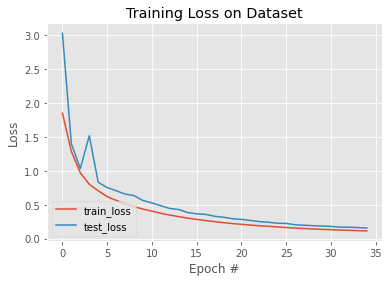

In [21]:
if (new_training):
  # plot the training loss
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(H["train_loss"], label="train_loss")
  plt.plot(H["test_loss"], label="test_loss")
  plt.title("Training Loss on Dataset")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss")
  plt.legend(loc="lower left")
  plt.savefig(config.PLOT_PATH)
  # serialize the model to disk
  torch.save(model, config.MODEL_PATH)

## RESULTS

In [22]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [23]:
IntToColor = {
    0: 'background',
    1: 'L1',
    2: 'L2',
    3: 'L3',
    4: 'L4',
    5: 'L5',
    6: 'S1'
}

classToColor = {
    'background': (0, 0, 0),
    'L1': (255, 255, 0),
    'L2': (255, 0, 0),
    'L3': (0, 255, 0),
    'L4': (0, 255, 255),
    'L5': (0, 0, 255),
    'S1': (255, 0, 255)
}

def IntToRGB(img):
  temp = np.zeros((img.shape[0], img.shape[1], 3))
  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      temp[i, j, :] = list(classToColor.get(IntToColor.get(img[i,j].item())))
  return temp

In [24]:
def onehot(mask, pred):
  y_true = F.one_hot(torch.LongTensor(RGBtoInt(mask))).numpy()
  y_pred = F.one_hot(pred, num_classes=7).numpy() 
  return y_true, y_pred

In [25]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index])
    return dice/numLabels # taking average

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


For original mask and predicted mask 0.9007585774433639


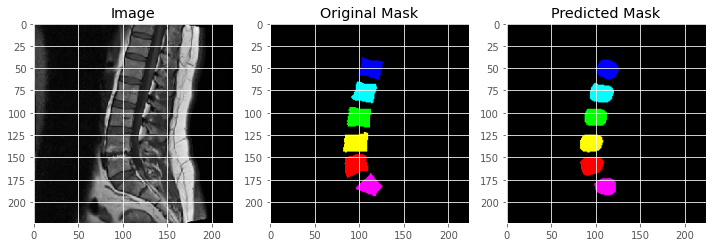

In [26]:
from skimage import io
from skimage import color
from skimage import segmentation

with torch.no_grad():
  model.eval()
  image = cv2.imread(ex_img_dir)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = image.astype("float32") / 255.0
  image = cv2.resize(image, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  orig = image.copy()

  gtMask = cv2.imread(ex_label_dir)
  gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_WIDTH, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
  gt_Mask_t = torch.tensor(gtMask)

  image = np.transpose(image, (2, 0, 1))
  image = np.expand_dims(image, 0)
  image = torch.from_numpy(image).to(config.DEVICE)
  predMask = model(image)
  predMask = predMask['out']
  predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
  #print(predMask.shape)
  predMask_RGB = IntToRGB(predMask)

  y_true, y_pred = onehot(gtMask, predMask)
  dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
  print(f'For original mask and predicted mask {dice_score}')

  prepare_plot(orig, gtMask, predMask_RGB)

In [30]:
def make_predictions(model, imagePath, labelPath, showPlot=True):
	# set model to evaluation mode
  model.eval()
	# turn off gradient tracking
  with torch.no_grad():

    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = image.astype("float32") / 255.0
    image = cv2.resize(image, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    orig = image.copy()

    groundTruthPath = labelPath
    gtMask = cv2.imread(groundTruthPath)
    gtMask = cv2.resize(gtMask, (config.INPUT_IMAGE_HEIGHT, config.INPUT_IMAGE_HEIGHT), interpolation = cv2.INTER_NEAREST)
    gt_Mask_t = torch.tensor(gtMask)
 
    image = np.transpose(image, (2, 0, 1))
    image = np.expand_dims(image, 0)
    image = torch.from_numpy(image).to(config.DEVICE)
    predMask = model(image)
    predMask = predMask['out']
    predMask = torch.argmax(predMask, 1).detach().cpu().squeeze()
    predMask_RGB = IntToRGB(predMask)
 
    y_true, y_pred = onehot(gtMask, predMask)
    dice_score = dice_coef_multilabel(y_true, y_pred, config.NUM_CLASS)
    #jaccard = jaccard_index(gt_Mask_t, predMask_np)
		# prepare a plot for visualization
    if (showPlot):
      print("dice_score = ", dice_score)
      prepare_plot(orig, gtMask, predMask_RGB)
    return dice_score

[INFO] loading up test image paths...
[INFO] load up model...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.890905978944753


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8882711980034731
dice_score =  0.8943166891233846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9078899091968592


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9064603404888735


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.889919682676134


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.916738627029595


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9040777522056248


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.9102336724820125


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dice_score =  0.8592513658405802
[0.890905978944753, 0.8882711980034731, 0.8943166891233846, 0.9078899091968592, 0.9064603404888735, 0.889919682676134, 0.916738627029595, 0.9040777522056248, 0.9102336724820125, 0.8592513658405802]


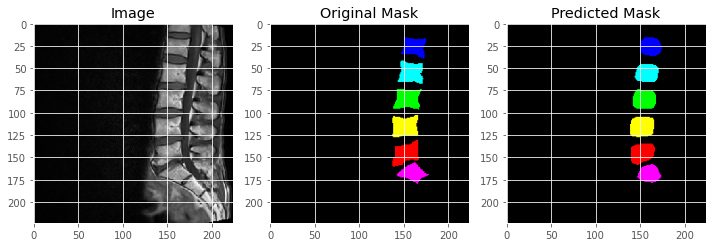

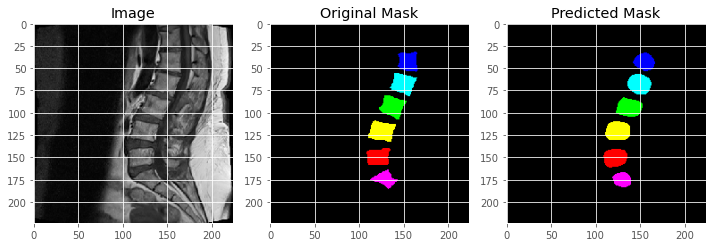

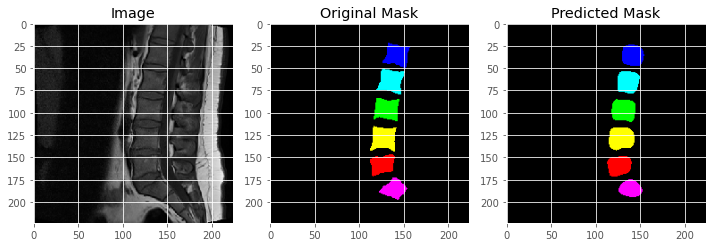

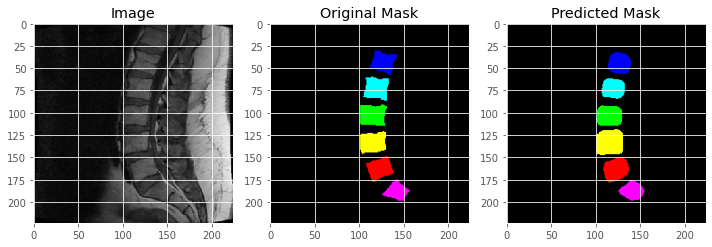

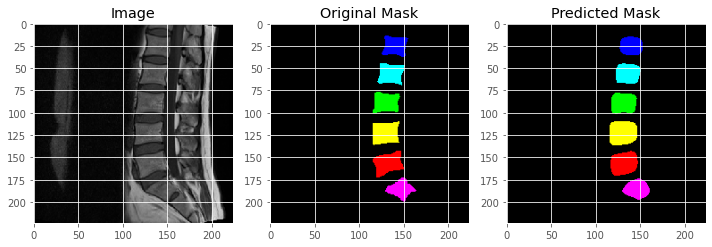

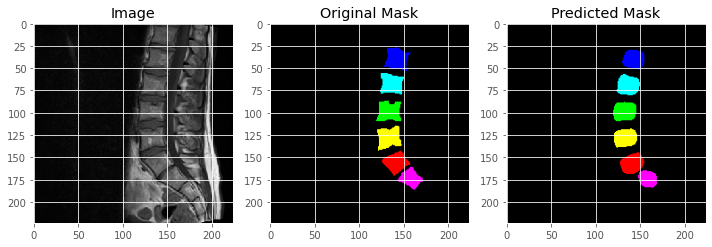

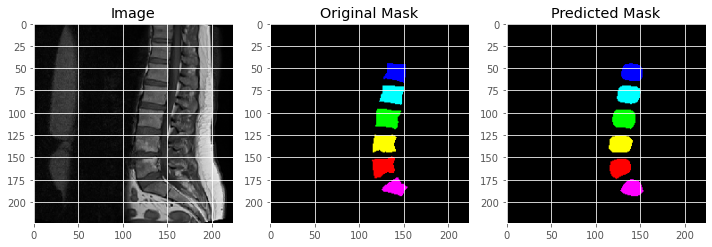

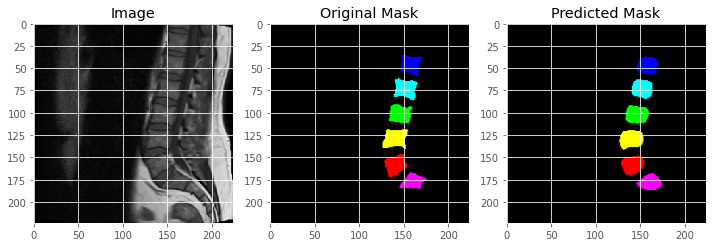

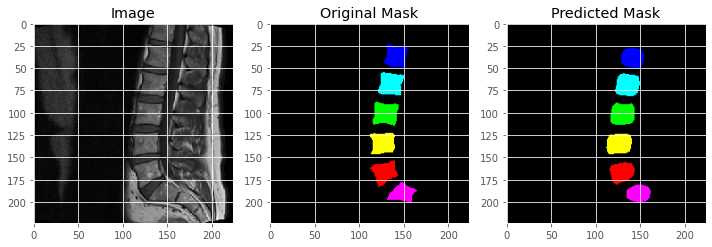

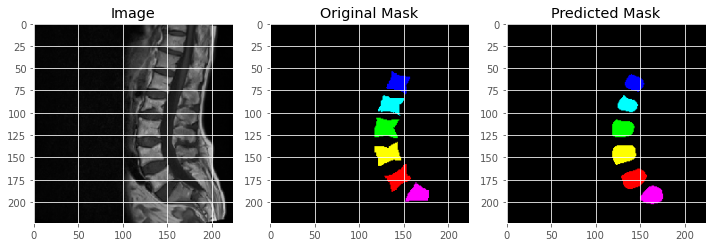

In [31]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
#imagePaths = open(config.TEST_PATHS).read().strip().split("\n")
imagePaths = np.random.choice(os.listdir(image_dir), size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over the randomly selected test image paths
dice_score_list = []
for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  dice_score= make_predictions(model, path, label_path)
  dice_score_list.append(dice_score)

print(dice_score_list)

## Box Plot of Dice Score
- just the test set

Median of dice score:  0.8957136718921169
25th percentile of dice score :  0.8859478729382855
75th percentile of dice score :  0.904043149821351


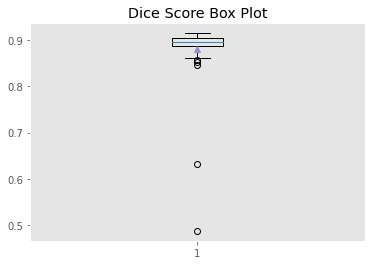

In [29]:
#Make box plots using the dice score of all the test results
imagePaths = val_list
model = torch.load(config.MODEL_PATH).to(config.DEVICE)
# iterate over all the test images
dice_score_list = []

for path in imagePaths:
	# make predictions and visualize the results
  temp = path
  path = os.path.join(image_dir, temp)
  label_path = os.path.join(label_dir, temp)
  score = make_predictions(model, path, label_path, showPlot=False)
  dice_score_list.append(score)

plt.boxplot(dice_score_list, showmeans=True)
plt.title("Dice Score Box Plot")
plt.grid()
print("Median of dice score: ", np.median(dice_score_list))
print("25th percentile of dice score : ",
       np.percentile(dice_score_list, 25))
print("75th percentile of dice score : ",
       np.percentile(dice_score_list, 75))